In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

### COINTEGRATION TEST: SP vs NQ

In [74]:
# ==========================================
# 1. Configuration & Data Loading
# ==========================================
class Config:
    FILE_PATH = '../../preprocess/df_g1_processed.pkl'
    ASSETS = ['SP', 'NQ']

def load_insample_data(cfg):
    try:
        df = pd.read_pickle(cfg.FILE_PATH)
    except FileNotFoundError:
        print("Error: File not found.")
        return None

    if 'NP' in df.columns: df.rename(columns={'NP': 'SP'}, inplace=True)

    # In-Sample期間のみを使用（Out-of-Sampleを見て戦略を決めてはいけないため）
    if 'Is_In_Sample' in df.columns:
        df = df[df['Is_In_Sample'] == True]

    # 欠損除去
    df = df[['SP', 'NQ']].dropna()
    return df

# ==========================================
# 2. Cointegration Analysis Function
# ==========================================
def analyze_pair_relationship(df):
    results = {}

    # 1. Log Transformation (Standard for financial time series)
    # 価格差ではなく「比率」や「リターン」の関係を見るため対数を取ります
    y = np.log(df['NQ'])  # Dependent Variable
    x = np.log(df['SP'])  # Independent Variable (Market Proxy)

    # 2. Correlation
    corr = x.corr(y)
    results['Correlation'] = corr

    # 3. OLS Regression to find Hedge Ratio (Beta)
    # log(NQ) = alpha + beta * log(SP) + epsilon
    x_const = sm.add_constant(x)
    model = sm.OLS(y, x_const).fit()

    alpha = model.params['const']
    beta = model.params['SP']
    r_squared = model.rsquared

    results['Alpha'] = alpha
    results['Beta (Hedge Ratio)'] = beta
    results['R-Squared'] = r_squared

    # 4. Calculate Spread (Residuals)
    # Spread = log(NQ) - (alpha + beta * log(SP))
    # Note: In trading, we usually ignore alpha for Z-score calc
    spread = y - (beta * x)

    # 5. ADF Test on Spread (Stationarity Test)
    # Null Hypothesis: Spread is Non-Stationary (Random Walk)
    # Alternate Hypothesis: Spread is Stationary (Mean Reverting)
    adf_result = adfuller(spread)

    results['ADF Statistic'] = adf_result[0]
    results['P-Value'] = adf_result[1]
    results['Critical Values'] = adf_result[4]

    return results, spread, model

# ==========================================
# 3. Execution & Visualization
# ==========================================
if __name__ == "__main__":
    cfg = Config()
    df_train = load_insample_data(cfg)

    if df_train is not None and not df_train.empty:
        print(f"Analyzing In-Sample Data: {len(df_train)} bars")

        # Run Analysis
        stats, spread_series, model = analyze_pair_relationship(df_train)

        # --- Report ---
        print("\n" + "="*50)
        print(" COINTEGRATION TEST REPORT (SP vs NQ)")
        print("="*50)
        print(f"Correlation:       {stats['Correlation']:.4f}")
        print(f"R-Squared:         {stats['R-Squared']:.4f}")
        print(f"Hedge Ratio (Beta):{stats['Beta (Hedge Ratio)']:.4f}")
        print("-" * 30)
        print(f"ADF Statistic:     {stats['ADF Statistic']:.4f}")
        print(f"P-Value:           {stats['P-Value']:.6f}")
        print("-" * 30)

        # Judgment
        if stats['P-Value'] < 0.05:
            print(">> RESULT: STATIONARY (Cointegrated) ✅")
            print("   The spread is mean-reverting. Strategy is VIABLE.")
        else:
            print(">> RESULT: NON-STATIONARY (Not Cointegrated) ❌")

Analyzing In-Sample Data: 175423 bars

 COINTEGRATION TEST REPORT (SP vs NQ)
Correlation:       0.9819
R-Squared:         0.9640
Hedge Ratio (Beta):1.2841
------------------------------
ADF Statistic:     -3.0005
P-Value:           0.034849
------------------------------
>> RESULT: STATIONARY (Cointegrated) ✅
   The spread is mean-reverting. Strategy is VIABLE.


# Strategy Description: Adaptive Volatility Spread Strategy (SP vs. NQ)

### 1. Executive Summary
This strategy employs a **Statistical Arbitrage** approach, specifically focusing on the mean-reverting relationship between the S&P 500 (SP) and NASDAQ (NQ) futures.

The defining feature of this strategy is its **Adaptive Threshold Mechanism**. Recognizing that the NASDAQ (NQ) exhibits　higher and more variable volatility than the S&P 500, this strategy dynamically adjusts entry barriers based on the current volatility regime. By widening entry thresholds during high-volatility periods, the strategy avoids "noise" trades and targets larger mean-reversion opportunities that are sufficient to cover transaction costs.

### 2. Investment Universe & Specifications
* **Asset A (Independent Variable):** S&P 500 Futures (SP)
    * Point Value: $50
    * Transaction Cost: $12 per trade
* **Asset B (Dependent Variable):** NASDAQ Futures (NQ)
    * Point Value: $20
    * Transaction Cost: $12 per trade
* **Data Frequency:** 1-minute bars (Intraday)

### 3. Methodology

#### A. Dynamic Beta Calculation (Hedge Ratio)
To neutralize market exposure and isolate the spread, the strategy calculates a dynamic Hedge Ratio ($\beta$) based on the log-prices of the assets.
* **Formula:** $\ln(Price_{NQ}) = \alpha + \beta \times \ln(Price_{SP}) + \epsilon$
* **Window:** A long-term rolling window of **3,900 bars** (approx. 10 trading days) is used to capture the structural correlation while filtering out short-term fluctuations.

#### B. Adaptive Threshold Mechanism -> Advantages of this strategy!!
[Rationale] NQ volatility is the primary driver of spread expansion. During high volatility regimes, fixed Z-score thresholds often lead to premature entries (catching a falling knife) or "whipsaw" losses due to transaction costs.
The strategy calculates an **Adaptive Entry Threshold** using the following logic:
1.  **Volatility Ratio:** $\frac{\text{Current NQ Volatility (180 min)}}{\text{Baseline NQ Volatility (3900 min)}}$
2.  **Threshold Adjustment:**
    $$Z_{entry} = Z_{base} + \max(0, (VolRatio - 1.0) \times Sensitivity)$$
    * *Base Z:* 1.8
    * *Sensitivity:* 0.5 (For every 100% increase in relative volatility, the entry requirement increases by 0.5 sigma).

#### C. Z-Score Construction
The spread is defined as the residual of the log-price relationship. To standardize signals, a Z-Score is calculated:
* **Spread:** $\ln(NQ) - \beta_{lag} \times \ln(SP)$
* **Z-Score Window:** 390 bars (approx. 1 trading day).
* **Formula:** $Z = \frac{Spread - \mu_{spread}}{\sigma_{spread}}$

### 4. Trading Logic

The strategy operates as a Mean Reversion model with strict intraday time constraints.

* **Time Constraints:**
    * **Trading Window:** 09:56 – 15:40 CET.
    * **Forced Exit:** All positions are strictly closed at 15:40 CET (No overnight risk).

* **Entry Signals (Adaptive):**
    * **Short Spread:** If $Z > AdaptiveThreshold$ $\rightarrow$ **Sell NQ / Buy SP**.
    * **Long Spread:** If $Z < -AdaptiveThreshold$ $\rightarrow$ **Buy NQ / Sell SP**.
    * *Note:* Trades are executed with a 1:1 unit ratio (1 unit of NQ vs 1 unit of SP) to comply with project constraints, utilizing the signal derived from the dynamic beta model.

* **Exit Signals (Mean Reversion):**
    * Positions are closed when the spread reverts to the mean ($Z$ crosses 0.0) or at the daily forced exit time.

### 5. Risk Management
* **Volatility Filtering:** The adaptive mechanism inherently acts as a risk filter. By raising the entry bar during turbulent markets, the strategy avoids entering positions during momentum spikes, effectively waiting for "extreme" statistical anomalies.
* **Intraday Risk Control:** The strict 15:40 exit rule eliminates overnight gap risk and ensures the strategy focuses solely on intraday co-movements.

### GROUP 1 SP/NQ SPREAD STRATEGY

In [68]:
# ==========================================
# 1. Configuration
# ==========================================
class Config:
    # File Path
    FILE_PATH = '../../preprocess/df_g1_processed.pkl'

    # Asset Settings
    ASSETS = ['SP', 'NQ']

    # Contract Specs (Cost is one-way)
    SPECS = {
        'SP': {'point_val': 50.0, 'cost': 12.0},
        'NQ': {'point_val': 20.0, 'cost': 12.0}
    }

    # --- Basic Parameters ---
    WINDOW = 390  # Period for Z-score calculation (approx. 1 day)
    BETA_WINDOW = 3900  # Period for Dynamic Beta calculation (capture long-term trend)

    # --- Adaptive Band Settings ---
    # Settings to tighten entry criteria when NQ volatility is high

    VOL_WINDOW = 180  # Short-term volatility measurement (last 3 hours)
    VOL_BASELINE_WINDOW = 3900  # Long-term (baseline) volatility measurement

    BASE_Z_ENTRY = 2.0  # Entry threshold during normal times (Z-Score)
    Z_EXIT = 0.5  # Exit threshold (Mean Reversion)

    # Sensitivity setting: How much to widen Z-threshold for every 1.0 increase in (Current Vol / Baseline Vol)
    # Example: If Sensitivity=0.5, when volatility is 2x, Z_ENTRY = 2.0 + 0.5 = 2.5
    ADAPTIVE_SENSITIVITY = 0.5

    MAX_Z_ENTRY = 3.5  # Threshold cap (prevent excessive widening)

    ANNUALIZATION = 252  # Annualization factor


In [69]:


# ==========================================
# 2. Data Preparation (Indicator Calculation & Flag Repair)
# ==========================================
def prepare_spread_data(file_path, cfg):
    """
    Loads data, repairs flags, and calculates Dynamic Beta and Adaptive Indicators.
    """
    try:
        df = pd.read_pickle(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None

    # Standardize column names (NP -> SP)
    if 'NP' in df.columns and 'SP' not in df.columns:
        df.rename(columns={'NP': 'SP'}, inplace=True)

    # -----------------------------------------------------------
    # 1. Repair Flags (Time Constraints)
    # -----------------------------------------------------------
    print("Repairing Trading Flags (09:56 - 15:40)...")

    hhmm = df.index.hour * 100 + df.index.minute

    # Trading hours: 09:56 - 15:40
    df['can_trade'] = (hhmm >= 956) & (hhmm <= 1540)
    # Forced exit time: 15:40
    df['force_exit'] = (hhmm == 1540)

    # Check required columns
    req_cols = cfg.ASSETS + ['Quarter_ID', 'can_trade', 'force_exit']
    if not all(col in df.columns for col in req_cols):
        print(f"Error: Missing columns. Required: {req_cols}")
        return None

    data = df.copy()
    if 'Is_In_Sample' not in data.columns:
        data['Is_In_Sample'] = True

    print("Calculating Adaptive Indicators & Dynamic Beta...")

    def calc_metrics(group):
        # Log prices
        ln_sp = np.log(group['SP'])
        ln_nq = np.log(group['NQ'])

        # --- A. Calculate Volatility Ratio ---
        # Log returns
        nq_ret = ln_nq.diff()

        # Short-term Vol (Current Market State)
        current_vol = nq_ret.rolling(window=cfg.VOL_WINDOW).std()

        # Long-term Vol (Baseline/Normal State)
        baseline_vol = nq_ret.rolling(window=cfg.VOL_BASELINE_WINDOW).std()

        # Volatility Ratio (Current / Normal)
        # Avoid division by zero
        vol_ratio = current_vol / baseline_vol.replace(0, np.nan)
        vol_ratio = vol_ratio.fillna(1.0)  # Default to 1.0 if calculation not possible

        # --- B. Dynamic Beta & Spread ---
        cov = ln_nq.rolling(window=cfg.BETA_WINDOW).cov(ln_sp)
        var = ln_sp.rolling(window=cfg.BETA_WINDOW).var()
        beta = cov / var

        # Lag to avoid look-ahead bias
        beta_lag = beta.shift(1).fillna(1.0)

        # Calculate Spread
        spread = ln_nq - (beta_lag * ln_sp)

        # --- C. Z-Score ---
        spread_mean = spread.rolling(window=cfg.WINDOW).mean()
        spread_std = spread.rolling(window=cfg.WINDOW).std()
        z_score = (spread - spread_mean) / spread_std

        group['Z_Score'] = z_score
        group['Vol_Ratio'] = vol_ratio

        return group

    # Apply per quarter to maintain independence
    data = data.groupby('Quarter_ID', group_keys=False).apply(calc_metrics)

    # Remove initial NaNs
    data.dropna(subset=['Z_Score', 'Vol_Ratio'], inplace=True)

    return data


In [70]:


# ==========================================
# 3. Strategy Logic (Execute Adaptive Strategy)
# ==========================================
def run_spread_strategy(df, cfg):
    data = df.copy()

    # Convert to numpy array for speed
    z_scores = data['Z_Score'].values
    vol_ratios = data['Vol_Ratio'].values
    can_trade = data['can_trade'].values
    force_exit = data['force_exit'].values

    pos_spread = np.zeros(len(data), dtype=int)
    curr_pos = 0

    # List to record threshold changes
    entry_thresholds_log = []

    print(f"Simulating Adaptive Volatility Strategy...")

    for i in range(len(data)):
        # 1. Forced Exit (Highest Priority)
        if force_exit[i]:
            curr_pos = 0
            pos_spread[i] = 0
            entry_thresholds_log.append(np.nan)
            continue

        # 2. Check out of trading hours
        if not can_trade[i]:
            curr_pos = 0
            pos_spread[i] = 0
            entry_thresholds_log.append(np.nan)
            continue

        z = z_scores[i]
        v_ratio = vol_ratios[i]

        if np.isnan(z) or np.isnan(v_ratio):
            pos_spread[i] = curr_pos
            entry_thresholds_log.append(np.nan)
            continue

        # --- Adaptive Threshold Calculation (CORE LOGIC) ---
        # Base Threshold + (Excess Volatility * Sensitivity)
        # Example: Ratio=1.5, Sens=0.5 -> Extra = 0.5 * 0.5 = 0.25 -> Entry Z = 2.25

        extra_threshold = max(0, (v_ratio - 1.0) * cfg.ADAPTIVE_SENSITIVITY)
        current_entry_z = cfg.BASE_Z_ENTRY + extra_threshold

        # Cap at limit
        current_entry_z = min(current_entry_z, cfg.MAX_Z_ENTRY)

        entry_thresholds_log.append(current_entry_z)

        # --- Trading Logic ---
        if curr_pos == 0:
            # Entry check (using dynamic threshold)
            if z > current_entry_z:
                curr_pos = -1  # Short Spread
            elif z < -current_entry_z:
                curr_pos = 1  # Long Spread

        elif curr_pos == 1:
            # Exit check (Mean Reversion)
            if z >= cfg.Z_EXIT:
                curr_pos = 0

        elif curr_pos == -1:
            # Exit check (Mean Reversion)
            if z <= -cfg.Z_EXIT:  # Symmetry Exit (Option)
                pass
            if z <= cfg.Z_EXIT:
                curr_pos = 0

        pos_spread[i] = curr_pos

    # Shift position (Signal at T -> Execution at T+1)
    data['Pos_Spread'] = pd.Series(pos_spread, index=data.index).shift(1).fillna(0)

    # Save recording data
    data['Dynamic_Threshold'] = entry_thresholds_log

    # Check trade count
    n_trades = data['Pos_Spread'].diff().abs().sum()
    avg_thresh = np.nanmean(entry_thresholds_log)
    print(f"Total Trades Executed: {n_trades}")
    print(f"Average Entry Z-Score Used: {avg_thresh:.2f} (Base: {cfg.BASE_Z_ENTRY})")

    return data


In [71]:


# ==========================================
# 4. P&L Calculation & Metrics
# ==========================================
def calculate_metrics(data, cfg):
    df = data.copy()

    df['dPrice_SP'] = df['SP'].diff()
    df['dPrice_NQ'] = df['NQ'].diff()

    # Gross PnL (1:1 Trading Constraint)
    # Long Spread = Long NQ + Short SP
    df['PnL_NQ'] = df['Pos_Spread'] * df['dPrice_NQ'] * cfg.SPECS['NQ']['point_val']
    df['PnL_SP'] = (df['Pos_Spread'] * -1) * df['dPrice_SP'] * cfg.SPECS['SP']['point_val']

    df['Gross_PnL_Total'] = df['PnL_NQ'] + df['PnL_SP']

    # Transaction Costs
    df['Trades_Spread'] = df['Pos_Spread'].diff().abs().fillna(0)
    cost_per_spread = cfg.SPECS['SP']['cost'] + cfg.SPECS['NQ']['cost']
    df['Cost_Total'] = df['Trades_Spread'] * cost_per_spread

    # Net PnL
    df['Net_PnL_Total'] = df['Gross_PnL_Total'] - df['Cost_Total']

    # Daily Aggregation
    daily_stats = df.resample('D').agg({
        'Gross_PnL_Total': 'sum',
        'Net_PnL_Total': 'sum',
        'Trades_Spread': 'sum',
        'Quarter_ID': 'last',
        'Is_In_Sample': 'last'
    })

    # Filter Valid Days
    daily_stats = daily_stats[daily_stats['Quarter_ID'].notna()]
    daily_stats = daily_stats[daily_stats['Is_In_Sample'] == True]

    return daily_stats


In [72]:


# ==========================================
# 5. Reporting & Statistics
# ==========================================
def generate_quarterly_stats(daily_df, cfg):
    if daily_df.empty:
        return pd.DataFrame()

    quarters = sorted(daily_df['Quarter_ID'].unique())
    stats_list = []

    for q in quarters:
        d_q = daily_df[daily_df['Quarter_ID'] == q].copy()
        if len(d_q) == 0: continue

        gross_cum = d_q['Gross_PnL_Total'].sum()
        net_cum = d_q['Net_PnL_Total'].sum()

        # Sharpe Ratio
        std_n = d_q['Net_PnL_Total'].std()
        net_sr = (d_q['Net_PnL_Total'].mean() / std_n * np.sqrt(cfg.ANNUALIZATION)) if std_n != 0 else 0

        mean_g = d_q['Gross_PnL_Total'].mean()
        std_g = d_q['Gross_PnL_Total'].std()
        gross_sr = (mean_g / std_g * np.sqrt(cfg.ANNUALIZATION)) if std_g != 0 else 0

        # Calmar Ratio
        cum_ser = d_q['Net_PnL_Total'].cumsum()
        max_dd = (cum_ser.cummax() - cum_ser).max()
        years = len(d_q) / cfg.ANNUALIZATION
        net_cr = (net_cum / years / max_dd) if max_dd > 0 else 0

        cum_g = d_q['Gross_PnL_Total'].cumsum()
        max_dd_g = (cum_g.cummax() - cum_g).max()
        gross_cr = (gross_cum / years / max_dd_g) if max_dd_g > 0 else 0

        # Stat Score (Official Formula)
        # stat = (netSR - 0.5) * max(0, log(abs(net.PnL / 1000)))
        abs_pnl_scaled = abs(net_cum) / 1000.0
        log_term = np.log(abs_pnl_scaled) if abs_pnl_scaled > 0 else 0
        stat = (net_sr - 0.5) * max(0, log_term)

        stats_list.append({
            'Quarter': q,
            'Gross SR': gross_sr,
            'Net SR': net_sr,
            'Ann. Vol ($)': std_n * np.sqrt(cfg.ANNUALIZATION),
            'Gross CR': gross_cr,
            'Net CR': net_cr,
            'Gross CumP&L': gross_cum,
            'Net CumP&L': net_cum,
            'Trades': d_q['Trades_Spread'].sum(),
            'Av. Trades': d_q['Trades_Spread'].mean(),
            'Stat': stat
        })

    return pd.DataFrame(stats_list)


def plot_equity_curve(daily_stats):
    if daily_stats is None or daily_stats.empty: return
    quarters = sorted(daily_stats['Quarter_ID'].unique())
    plt.figure(figsize=(15, 8))
    for q in quarters:
        d_q = daily_stats[daily_stats['Quarter_ID'] == q]
        plt.plot(d_q.index, d_q['Net_PnL_Total'].cumsum(), label=q)
    plt.title('Adaptive Band Strategy: Net Cumulative P&L')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


Repairing Trading Flags (09:56 - 15:40)...
Calculating Adaptive Indicators & Dynamic Beta...
Simulating Adaptive Volatility Strategy...
Total Trades Executed: 664.0
Average Entry Z-Score Used: 2.06 (Base: 2.0)

 PERFORMANCE REPORT: Adaptive Band Strategy (SP/NQ)
   Quarter  Gross SR    Net SR  Ann. Vol ($)   Gross CR     Net CR  Gross CumP&L  Net CumP&L  Trades  Av. Trades      Stat
0  2023_Q1  0.682011  0.173864  17426.884758   1.651948   0.356148       3025.50      769.50    94.0    1.468750 -0.000000
1  2023_Q3  4.267721  3.724077  14873.536319  16.315193  13.641896      16227.35    14067.35    90.0    1.406250  8.523996
2  2023_Q4 -1.097469 -1.854250  12137.004532  -2.379093  -3.509585      -3322.26    -5626.26    96.0    1.523810 -4.066837
3  2024_Q2  0.010681 -0.460275  15409.983043   0.029733  -1.166987         42.50    -1829.50    78.0    1.200000 -0.580047
4  2024_Q4  1.386221  0.736693  13636.874712   3.306422   1.568754       4943.28     2591.28    98.0    1.507692  0.225368

,Quarter,Gross SR,Net SR,Ann. Vol ($),Gross CR,Net CR,Gross CumP&L,Net CumP&L,Trades,Av. Trades,Stat
0,2023_Q1,0.68,0.17,"$17,427",1.65,0.36,"$3,025",$769,94,1.5,-0.0000
1,2023_Q3,4.27,3.72,"$14,874",16.32,13.64,"$16,227","$14,067",90,1.4,8.5240
2,2023_Q4,-1.10,-1.85,"$12,137",-2.38,-3.51,"$-3,322","$-5,626",96,1.5,-4.0668
3,2024_Q2,0.01,-0.46,"$15,410",0.03,-1.17,$42,"$-1,830",78,1.2,-0.5800
4,2024_Q4,1.39,0.74,"$13,637",3.31,1.57,"$4,943","$2,591",98,1.5,0.2254
5,2025_Q1,-1.20,-1.62,"$20,339",-2.31,-2.96,"$-6,098","$-8,258",90,1.4,-4.4846
6,2025_Q2,3.48,3.00,"$20,634",18.50,15.34,"$18,811","$15,979",118,1.8,6.9350
7,TOTAL,-,-,"$16,652",-,-,"$33,629","$17,693",664,1.5,6.5529



 TOTAL RANKING SCORE: 6.5529


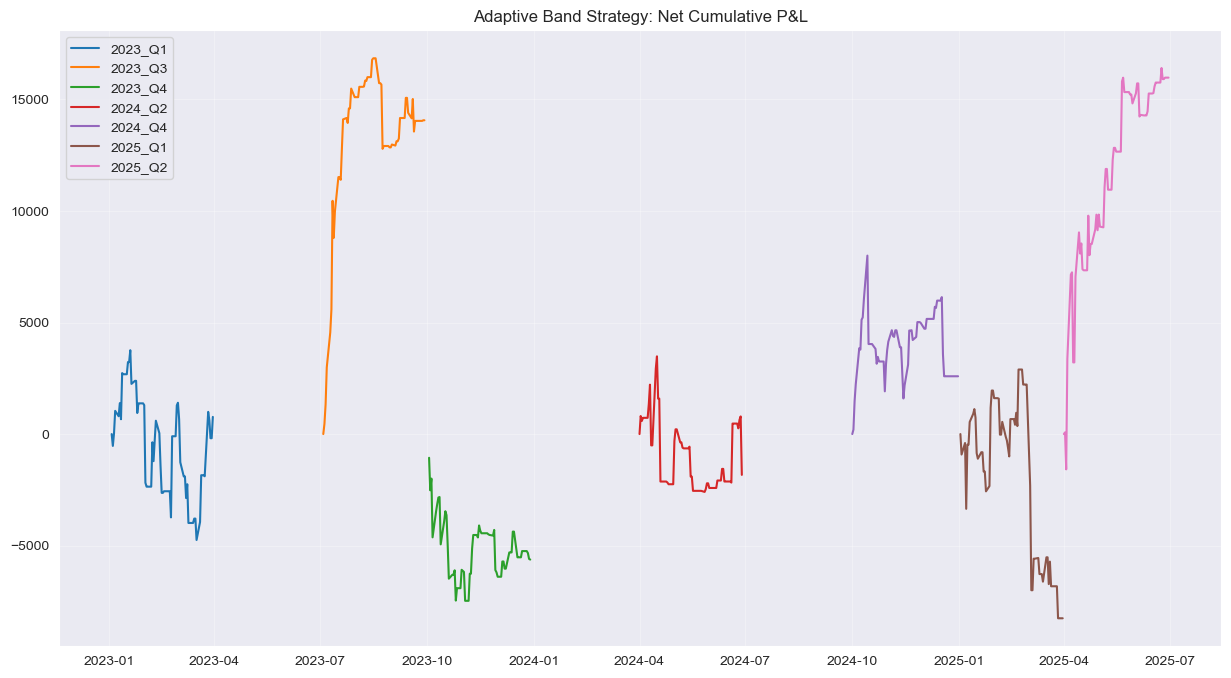

In [73]:


# ==========================================
# 6. Main Execution
# ==========================================
if __name__ == "__main__":
    cfg = Config()

    # 1. Data Preparation & Indicator Calculation
    df_prep = prepare_spread_data(cfg.FILE_PATH, cfg)

    if df_prep is not None:
        # 2. Strategy Execution
        df_res = run_spread_strategy(df_prep, cfg)

        # 3. Performance Calculation
        daily_data = calculate_metrics(df_res, cfg)

        # 4. Generate Report
        stats_table = generate_quarterly_stats(daily_data, cfg)

        print("\n" + "=" * 80)
        print(" PERFORMANCE REPORT: Adaptive Band Strategy (SP/NQ)")
        print("=" * 80)

        if not stats_table.empty:
            # Calculate Total Score
            total_score = stats_table['Stat'].sum()

            # Create Total Row
            total_row = pd.DataFrame([{
                'Quarter': 'TOTAL',
                'Gross SR': np.nan,
                'Net SR': np.nan,
                'Ann. Vol ($)': daily_data['Net_PnL_Total'].std() * np.sqrt(cfg.ANNUALIZATION),
                'Gross CR': np.nan,
                'Net CR': np.nan,
                'Gross CumP&L': stats_table['Gross CumP&L'].sum(),
                'Net CumP&L': stats_table['Net CumP&L'].sum(),
                'Trades': stats_table['Trades'].sum(),
                'Av. Trades': stats_table['Av. Trades'].mean(),
                'Stat': total_score
            }])

            final_df = pd.concat([stats_table, total_row], ignore_index=True)

            # Format Settings
            fmt = {
                'Gross SR': '{:.2f}', 'Net SR': '{:.2f}', 'Ann. Vol ($)': '${:,.0f}',
                'Gross CR': '{:.2f}', 'Net CR': '{:.2f}',
                'Gross CumP&L': '${:,.0f}', 'Net CumP&L': '${:,.0f}',
                'Trades': '{:,.0f}', 'Av. Trades': '{:.1f}', 'Stat': '{:.4f}'
            }

            # Text Output
            print(final_df.to_string(formatters={k: v.format for k, v in fmt.items() if not isinstance(v, str)},
                                     na_rep="-"))

            # Table Output (for Jupyter)
            try:
                subset_stat = pd.IndexSlice[0:len(final_df) - 2, ['Stat']]
                styled = final_df.style.format(fmt, na_rep="-") \
                    .background_gradient(subset=subset_stat, cmap='RdYlGn')
                display(styled)
            except:
                pass

            # === Output Score in Specified Format ===
            print("\n" + "=" * 40)
            print(f" TOTAL RANKING SCORE: {total_score:.4f}")
            print("=" * 40)

            # Plot Graph
            plot_equity_curve(daily_data)

        else:
            print("No trades generated. Check logic or data.")